<a href="https://colab.research.google.com/github/alanwuha/the-annotated-transformer/blob/master/the-annotated-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Is All You Need

## Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include and __encoder__ and a __decoder__. The best performing models also connect the encoder and decoder through an attention mechanism.

We propose a new simple network architecture, the __Transformer__, __based solely on attention mechanisms__, dispensing with recurrence and convolutions entirely.

Experiments on __two machine translation tasks__ show these models to be __superior in quality__ while being __more parallelizable__ and requiring significantly __less time to train__.

Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature.

We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.

## Major points of this new Transformer architecture:
1. Superior in quality
1. More parallelizable
1. Significantly less time to train

## Prelims

In [1]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 592.3MB 1.1MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

## Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building blocks, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequence aligned recurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

__To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.__

## Model Architecture

__Most competitive neural sequence transduction models have an encoder-decoder structure__.

Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn). Given __z__, the decoder then generates an output sequence (y1, ..., ym) of symbols one element at a time. At each step the model is __auto-regressive__, consuming the previously generated symbols as additional input when generating the next.

1. __Encoder__: maps input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn).
1. __Decoder__: given z, decoder generates an output sequence (y1, ..., ym) of symbols one element at a time.
1. __Auto-regressive__: A time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very __simple idea that can result in accurate forecasts on a range of time series problems__.

In [0]:
class EncoderDecoder(nn.Module):
  """
  A standard Encoder-Decoder architecture. Base for this and many other models.
  """
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask):
    "Take in and process masked src and target sequences."
    return self.decode( self.encode(src, src_mask), src_mask, tgt, tgt_mask )

  def encode(self, src, src_mask):
    return self.encoder( self.src_embed(src), src_mask )

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder( self.tgt_embed(tgt), memory, src_mask, tgt_mask )

In [0]:
class Generator(nn.Module):
  "Define standard linear + softmax generation step."
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

## Encoder and Decoder Stacks

### Encoder

The encoder is composed of a stack of N = 6 identical layers.

In [0]:
def clones(module, N):
  "Produce N identical layers."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class Encoder(nn.Module):
  "Core encoder is a stack of N layers"
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    "Pass the input (and mask) through each layer in turn."
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

We employ a residual connection [(cite)](https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by layer normalization [(cite)](https://arxiv.org/abs/1607.06450).

In [0]:
class LayerNorm(nn.Module):
  "Construct a layernorm module (See citation for details)."
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is __LayerNorm(x + Sublayer(x))__, where Sublayer(x) is the function implemented by the sub-layer itself. We apply dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension _d_<sub>model</sub> = 512.

In [0]:
class SublayerConnection(nn.Module):
  """
  A residual connection followed by a layer norm.
  Note for code simplicity the norm is first as opposed to last.
  """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    "Apply residual connection to any sublayer with the same size."
    return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [0]:
class EncoderLayer(nn.Module):
  "Encoder is made up of self-attention and feed forward (defined below)"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    "Follow Figure 1 (left) for connections."
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

### Decoder

The decoder is also composed of a stack of N = 6 identical layers.

In [0]:
class Decoder(nn.Module):
  "Generic N layer decoder with masking."
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [0]:
class DecoderLayer(nn.Module):
  "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    "Follow Figure 1 (right) for connections."
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position _i_ can depend only on the known outputs at positions less than _i_.

In [0]:
def subsequent_mask(size):
  "Mask out subsequent positions."
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

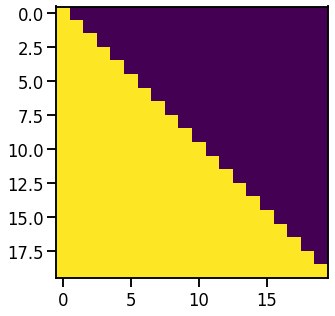

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call out particular attention "Scaled Dot-Product Attention". The input consists of queries and keys of dimension d<sub>k</sub>, and values of dimension d<sub>v</sub>. We compute the dot products of the query with all keys, divide each by sqrt(d<sub>k</sub>), and apply a softmax function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V. We compute the matrix of outputs as:

__`Attention(Q, K, V) = softmax(  QK^T / sqrt(d_k) ) * V`__

In [0]:
def attention(query, key, value, mask=None, dropout=None):
  qk = torch.mm(query, key)
  scale = (qk - qk.mean()) / (qk.std + eps)
  m = torch.mm(scale, mask)
  drop = F.dropout(m, dropout)
  soft = F.softmax(drop)
  return torch.mm(soft, value)

  "Compute 'Scaled Dot Product Attention'"
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim=-1)
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of 1/sqrt(dk). Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, __dot-product attention is much faster and more space-efficient in practice__, since it can be __implemented using highly optimized matrix multiplication code__.

While for small values of dk, the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of dk. We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients (To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product has mean 0 and variance dk). To counteract this effect, we scale the dot products by 1/sqrt(dk)).

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

In this work we employ h = 8 parallel attention layers, or heads. For each of these we use dk = dv = dmodel / h = 64. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

In [0]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    "Take in model size and number of heads."
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0
    # We assume d_v always equals d_k
    self.d_k = d_model // h
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    "Implements Figure 2"
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)
    nbatches = query.size(0)

    # 1) Do all the linear projections in batch from d_model => h x d_k
    query, key, value = \
      [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for l, x in zip(self.linears, (query, key, value))]

    # 2) Apply attention on all the projected vectors in batch.
    x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

    # 3) "Concat" using a view and apply a final linear.
    x = x.transpose(1, 2).contiguous() \
          .view(nbatches, -1, self.h * self.d_k)
    return self.linears[-1](x)

## Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways:

1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models as such [(cite)](https://arxiv.org/abs/1609.08144).

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values, and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to -inf) all values in the input of the softmax which correspond to illegal connections.

_What does it mean by illegal connections?_

### Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

`FFN(x) = max(0, xW1 + b1) W2 + b2

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is d<sub>model</sub> = 512, and the inner-layer has dimensionality d<sub>dd</sub> = 2048.

In [0]:
class PositionwiseFeedForward(nn.Module):
  "Implements FFN equation."
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Embeddings and Softmax

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension d<sub>model</sub>. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](#). In the embedding layers, we multiply those weights by sqrt(d<sub>model</sub>).

[Definition of transduction](https://machinelearningmastery.com/transduction-in-machine-learning/): To transduce means to convert something into another form.

In [0]:
class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embeddings, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model

  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension d<sub>model</sub> as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed.

In this work, we use sine and cosine functions of different frequencies:
- PE(pos, 2i) = sin(pos/10000^2i/dmodel)
- PE(pos, 2i+1) = cos(pos/10000^2i/dmodel)
where _pos_ is the position and _i_ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2pi to 10000*2pi. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PE_pos+k can be represented as a linear function of PE_pos.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of P_drop = 0.1.


In [0]:
class PositionalEncoding(nn.Module):
  "Implement the PE function."
  def __init__(self, d_model, dropout, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
    return self.dropout(x)

Below the positional encoding will add in a since wave based on position. The frequency and offset of the wave is different for each dimension.

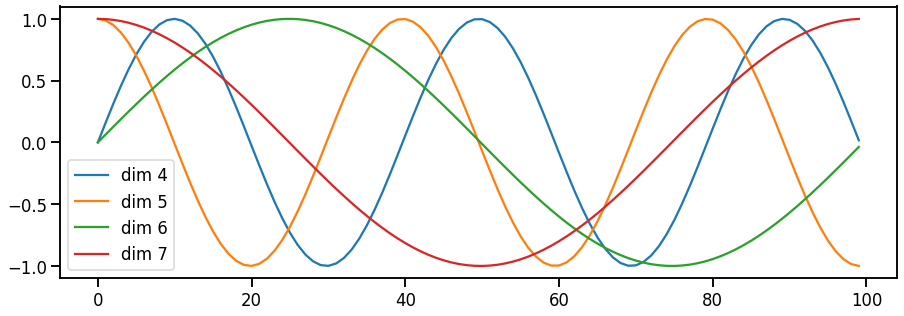

In [19]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

__We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results.__

We chose the __sinusoidal version__ because it __may allow the model to extrapolate to sequence lengths longer than the ones encountered during training__.

### Full Model

Here we define a function that takes in hyperparameters and produces a full model.

In [0]:
def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.1):
  "Helper: Construct a model from hyperparameters."
  c = copy.deepcopy
  attn = MultiHeadedAttention(h, d_model)
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
      Generator(d_model, tgt_vocab)
  )

  # This was important from their code.
  # Initialize parameters with Glorot / fan_avg.
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
  return model

In [0]:
# Small example model.
tmp_model = make_model(10, 10, 2)
None

### Training

This section describes the training regime for our models.

_We stop for a quick interlude to introduce some of the tools needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.

### Batches and Masking

In [0]:
class Batch:
  "Object for holding a batch of data with mask during training."
  def __init__(self, src, trg=None, pad=0):
    self.src = src
    self.src_mask = (src != pad).unsqueeze(-2)
    if trg is not None:
      self.trg = trg[:, :-1]
      self.trg_y = trg[:, 1:]
      self.trg_mask = self.make_std_mask(self.trg, pad)
      self.ntokens = (self.trg_y != pad).data.sum()

  @staticmethod
  def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
        subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
    )
    return tgt_mask

Next we create a generic training and scoring funtion to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.

### Training Loop

In [0]:
def run_epoch(data_iter, model, loss_compute):
  "Standard Training and Logging Function"
  start = time.time()
  total_tokens = 0
  total_loss = 0
  tokens = 0
  for i, batch in enumerate(data_iter):
    out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
    loss = loss_compute(out, batch.trg_y, batch.ntokens)
    total_loss += loss
    total_tokens += batch.ntokens
    tokens += batch.ntokens
    if i % 50 == 1:
      elapsed = time.time() - start
      print("Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.ntokens, tokens / elapsed))
      start = time.time()
      tokens = 0
  return total_loss / total_tokens

### Training Data and Batching

We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs. Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary.

Sentence pairs were batched together by approximately sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

_We will use torch text for batching. This is discussed in more detail below. Here we create batches in a torchtext function that ensures our batch size padded to the maaximum batchsize does not surpass a threshold (25000 if we have 8 gpus).

In [0]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
  "Keep augmenting batch and calculate total number of tokens + padding."
  global max_src_in_batch, max_tgt_in_batch
  if count == 1:
    max_src_in_batch = 0
    max_tgt_in_batch = 0
  max_src_in_batch = max(max_src_in_batch, len(new.src))
  max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
  src_elements = count * max_src_in_batch
  tgt_elements = count * max_tgt_in_batch
  return max(src_elements, tgt_elements)

### Hardware and Schedule

We trained our models on one machine with 8 NVIDIA P100 GPUs. For our base models using the hyperparameters described through the paper, each training step took about 0.4 seconds. We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days).

### Optimizer

We used the Adam optimizer with b1 = 0.9, b2 = 0.98 and e = 10^-9. We varied the learning rate over the course of training, according to the formula: lrate = dmodel^-0.5 * min(step_num^-0.5, step_num * warmupsteps^-1.5). This corresponds to increasing the learning rate linearly for the first warmupsteps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used warmupsteps = 4000.

> Note: This part is very important. Need to train with this setup of the model.

In [0]:
class NoamOpt:
  "Optim wrapper that implements rate."
  def __init__(self, model_size, factor, warmup, optimizer):
    self.optimizer = optimizer
    self._step = 0
    self.warmup = warmup
    self.factor = factor
    self.model_size = model_size
    self._rate = 0

  def step(self):
    "Update parameters and rate"
    self._step += 1
    rate = self.rate()
    for p in self.optimizer.param_groups:
      p['lr'] = rate
    self._rate = rate
    self.optimizer.step()

  def rate(self, step = None):
    "Implement `lrate` above"
    if step is None:
      step = self._step
    return self.factor * \
        (self.model_size ** (-0.5) * 
         min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
  def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                  torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

> Example of the curves of this model for different model sizes and for optimization hyperparameters.

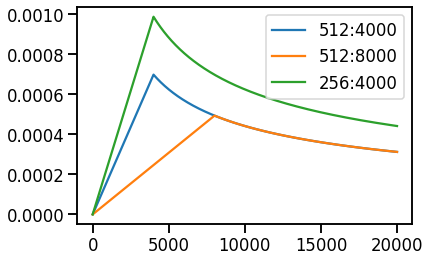

In [27]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

### Regularization

### Label Smoothing

During training, we employed label smoothing of value els = 0.1. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [0]:
class LabelSmoothing(nn.Module):
  "Implement label smoothing."
  def __init__(self, size, padding_idx, smoothing=0.0):
    super(LabelSmoothing, self).__init__()
    self.criterion = nn.KLDivLoss(size_average=False)
    self.padding_idx = padding_idx
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.size = size
    self.true_dist = None

  def forward(self, x, target):
    assert x.size(1) == self.size
    true_dist = x.data.clone()
    true_dist.fill_(self.smoothing / (self.size - 2))
    true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
    true_dist[:, self.padding_idx] = 0
    mask = torch.nonzero(target.data == self.padding_idx)
    if mask.dim() > 0:
      true_dist.index_fill_(0, mask.squeeze(), 0.0)
    self.true_dist = true_dist
    return self.criterion(x, Variable(true_dist, requires_grad=False))

> Here we can see an example of how the mass is distributed to the words based on confidence.

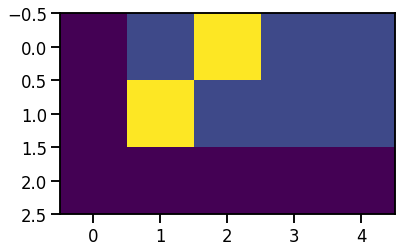

In [29]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()),
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

> Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

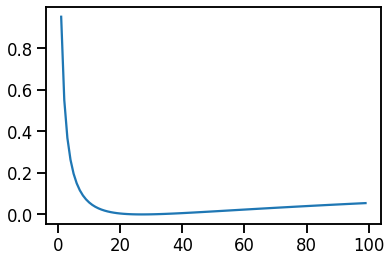

In [32]:
crit = LabelSmoothing(5, 0, 0.1)

def loss(x):
  d = x + 3 * 1
  predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d],])

  # print(predict)
  return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).data[0]


plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None